In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# real-value function with one minimum

We want to fit the following function $ f_\alpha: D \subset \mathbb{R}^2 \rightarrow \mathbb{R}$, $ f_\alpha(x_1, x_2) = \alpha \left({x_1}^2 + {x_2}^2 \right) $, $D = [-3, 3]^2$ 

In [190]:
def f(x1, x2, alpha=1.):
    return alpha * (x1**2 + x2**2)

1. Generate training data

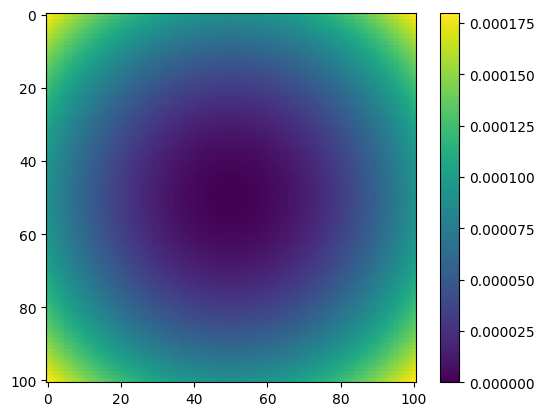

In [191]:
def generate_data(f, N=101):
    
    # create grid
    x1 = x2 = torch.linspace(-3, 3, N)
    grid_x1, grid_x2 = torch.meshgrid(x1, x2, indexing='ij')
    x = torch.stack((grid_x1, grid_x2))
    x = torch.moveaxis(x, 0, -1)
    x_train = x.view(N*N, 2)
    
    # evaluate on grid
    y = f(grid_x1, grid_x2)
    y_train = y.view(N*N, 1)
    
    # normalize
    norm_factor = y_train.sum() / y_train.shape[0]
    
    return x, y, x_train, y_train, norm_factor

from functools import partial
f_alpha = partial(f, alpha=1e-5)
N = 101
x, y, x_train, y_train, norm_factor = generate_data(f_alpha, N)

fig, ax = plt.subplots()
im = ax.imshow(y)
#im = ax.imshow(y_flat.reshape(N, N))
fig.colorbar(im)

2. initialize feed forward neural network

In [192]:
from torch import nn
from models import FeedForwardNN
model = FeedForwardNN(
    d_in=2,
    d_out=1,
    hidden_sizes=[32, 32, 32, 32],
    activation=nn.Tanh(),
    #output_activation=nn.Linear(1, 1, bias=False),
    output_activation=nn.Identity(),
)

3. Define optimization routine 

In [193]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)

4. Define loss

In [194]:
loss_func = nn.MSELoss()

5. Train

In [196]:
def train(model, x_train, y_train, n_iterations=10, batch_size=10):
    for i in range(n_iterations):
    
        # sample data
        idx = torch.randint(0, x_train.shape[0], (batch_size,))
        
        # compute model prediction
        pred = model(x_train[idx])
        
        # compute loss
        loss = loss_func(pred, y_train[idx] / norm_factor)

        # compute gradient
        loss.backward()
        opt.step()
        opt.zero_grad()
    
        if i % int(1e2) == 0:
            print('it: {:d}, loss: {:.3e}'.format(i, loss))
        
train(model, x_train, y_train, n_iterations=2000, batch_size=100)

it: 0, loss: 1.149e-03
it: 100, loss: 4.933e-04
it: 200, loss: 7.409e-05
it: 300, loss: 9.879e-04
it: 400, loss: 2.190e-04
it: 500, loss: 1.101e-03
it: 600, loss: 1.323e-03
it: 700, loss: 3.632e-03
it: 800, loss: 7.342e-04
it: 900, loss: 1.096e-03
it: 1000, loss: 5.619e-04
it: 1100, loss: 4.144e-04
it: 1200, loss: 1.474e-04
it: 1300, loss: 4.568e-03
it: 1400, loss: 2.314e-04
it: 1500, loss: 9.962e-03
it: 1600, loss: 1.211e-04
it: 1700, loss: 1.982e-04
it: 1800, loss: 1.316e-04
it: 1900, loss: 4.360e-04


6. Re-scale model

In [197]:
def modify(model, norm_factor):
    model.model[-1] = nn.Linear(1, 1, bias=False)
    with torch.no_grad():
        model.model[-1].weight[0, 0] = norm_factor.item()

modify(model, norm_factor)

6. Evaluate

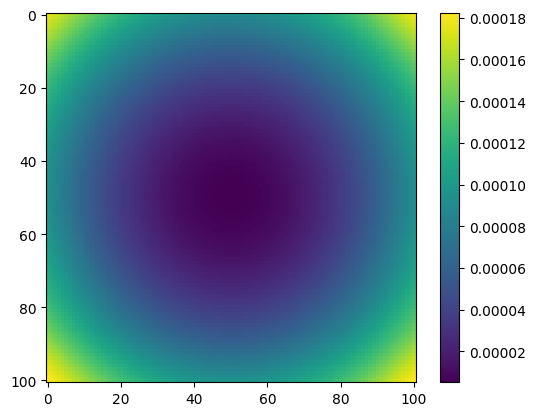

In [198]:
def evaluate(model):
    
    with torch.no_grad():
        y_pred = model.forward(x)

    fig, ax = plt.subplots()
    im = ax.imshow(y_pred)
    fig.colorbar(im)

evaluate(model)

# Volcano

$ f: D \subset \mathbb{R}^2 \rightarrow \mathbb{R}$, $ g(x_1, x_2) = \sin{\bigl( \sqrt{{x_1}^2 + {x_2}^2} \bigr)}$, $D = [-5, 5]^2$

In [199]:
def f(x1, x2, alpha=1.):
    return  alpha * np.sin(np.sqrt(x1**2 + x2**2))

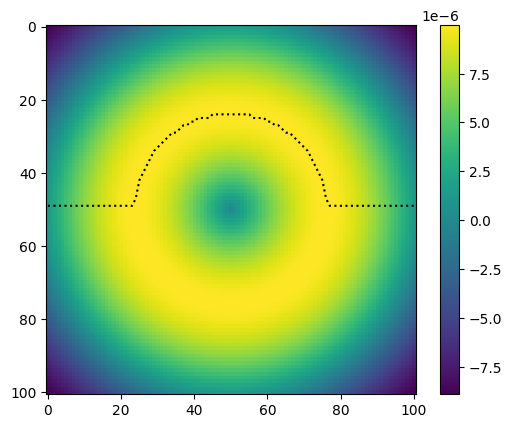

In [200]:
f_alpha = partial(f, alpha=1e-5)
N = 101
x, y, x_train, y_train, norm_factor = generate_data(f_alpha, N)
z = torch.argmax(y[:, 0:50], axis=1)
fig, ax = plt.subplots()
im = ax.imshow(y)
fig.colorbar(im)
ax.plot(z, c='black', ls=':')

In [201]:
model = FeedForwardNN(d_in=2, d_out=1, hidden_sizes=[32, 32, 32, 32], 
                      activation=nn.Tanh(), output_activation=nn.ReLU())
opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
loss_func = nn.MSELoss()
train(model, x_train, y_train, n_iterations=2000, batch_size=100)

it: 0, loss: 1.850e+00
it: 100, loss: 1.521e-01
it: 200, loss: 1.429e-01
it: 300, loss: 9.062e-02
it: 400, loss: 1.176e-01
it: 500, loss: 1.470e-01
it: 600, loss: 9.146e-02
it: 700, loss: 1.432e-01
it: 800, loss: 7.304e-02
it: 900, loss: 1.032e-01
it: 1000, loss: 1.165e-01
it: 1100, loss: 1.082e-01
it: 1200, loss: 1.203e-01
it: 1300, loss: 1.501e-01
it: 1400, loss: 2.026e-01
it: 1500, loss: 6.843e-02
it: 1600, loss: 2.004e-01
it: 1700, loss: 1.194e-01
it: 1800, loss: 1.337e-01
it: 1900, loss: 1.766e-01


In [202]:
modify(model, norm_factor)

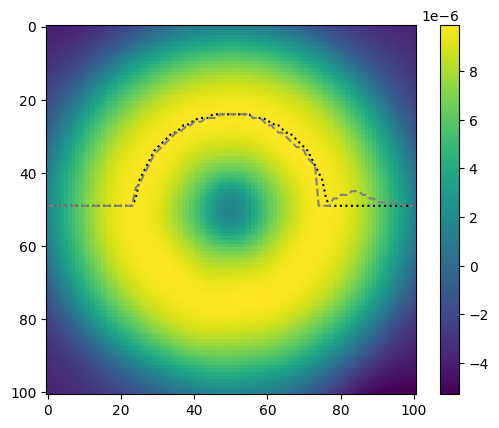

In [203]:
# evaluate
with torch.no_grad():
    y_pred = model.forward(x)

z_pred = torch.argmax(y_pred[:, 0:50], axis=1)    
    
fig, ax = plt.subplots()
im = ax.imshow(y_pred)
fig.colorbar(im)
ax.plot(z, c='black', ls=':')
ax.plot(z_pred, c='grey', ls='--')

# Another example

In [204]:
def f(x1, x2):
    return  x2 - x1**2 -1

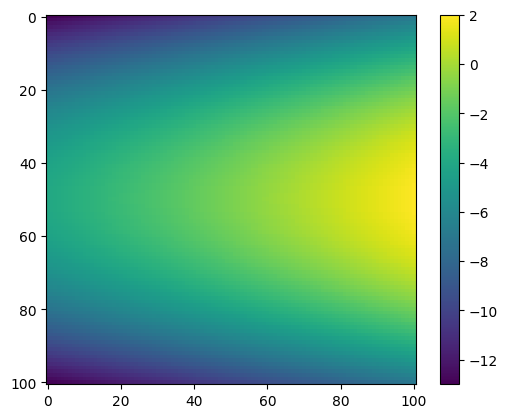

In [206]:
x, y, x_train, y_train, norm_factor = generate_data(f, 101)
fig, ax = plt.subplots()
im = ax.imshow(y)
fig.colorbar(im)

In [208]:
model = FeedForwardNN(d_in=2, d_out=1, hidden_sizes=[32, 32, 32, 32], 
                      activation=nn.Tanh(), output_activation=nn.Identity())
opt = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
loss_func = nn.MSELoss()
train(model, x_train, y_train, n_iterations=2000, batch_size=100)

it: 0, loss: 1.739e+00
it: 100, loss: 3.394e-03
it: 200, loss: 8.354e-04
it: 300, loss: 1.670e-03
it: 400, loss: 2.199e-04
it: 500, loss: 6.683e-03
it: 600, loss: 3.549e-04
it: 700, loss: 3.015e-04
it: 800, loss: 4.692e-04
it: 900, loss: 1.017e-03
it: 1000, loss: 5.152e-04
it: 1100, loss: 1.210e-04
it: 1200, loss: 4.168e-04
it: 1300, loss: 2.896e-04
it: 1400, loss: 1.162e-03
it: 1500, loss: 2.814e-03
it: 1600, loss: 5.964e-05
it: 1700, loss: 7.104e-05
it: 1800, loss: 8.152e-04
it: 1900, loss: 3.945e-04


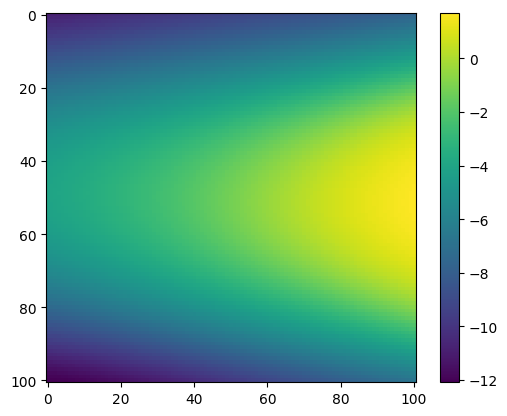

In [209]:
modify(model, norm_factor)
evaluate(model)